### Summary

After analyzing the penetration for signups, KYC completed users, and current MAUs(exclude the fraud users). We have following insights from the EDA:
1. Penetration - signups
    Large cities with good sign up amounts do not have good penetration
    In terms of state, FL is the winner, GA performs well both in absolute signups and penetration
    In terms of Area: South-eastern area > North-eastern and central area > West Coast
    Potential markets in big cities and cities in west coast 
2. Penetration - KYCC
    Absolute amount is similar to signups
    Penetration rank is different - some central states shows up in the list, including New York
3. Penetration - Current MAU
    Similar to KYCC penetration, however, Fort Lauderdale which is the top in earlier penetration rank is not on this list

In [1]:
import numpy as np
import pandas as pd
import copy
from utils.datalib_database import df_from_sql
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
import altair as alt
import datetime as dt
from datetime import date


import warnings

warnings.filterwarnings("ignore")
import subprocess

### Data Import and Overview

Import internal data signups, KYCC, current MAU with their first shipping address from Metabase, then compare with the census data. Clean the invalid data before the EDA

In [2]:
# import from drives
# data can be found in - https://drive.google.com/drive/folders/1U8tKbmFj2xf0o3MZmxICozyd65hCcSrx?usp=sharing, name is the same as below
pop = pd.read_csv("popestimate2019.csv")
# n26pop = pd.read_csv('first_shipping_address.csv')

In [3]:
# sql query to pull the internal data, same as "first_shipping_address"
query = """
select 
  a.city, 
  a.state, 
  count(distinct a.user_id) as signups 
from dbt.dim_address a 
join dbt.dim_users u on u.user_id = a.user_id
where a.type = 'FIRST_SHIPPING'
  and u.first_fraud_flag is null
group by 1, 2 
order by 3 desc
"""

In [4]:
cmau = """
with current_mau as 
(select 
    distinct user_id
  from dbt.f_user_activity_txn
  where current_date between activity_start and activity_end 
    and activity_type = '1_tx_35'
    )
select 
  a.city, 
  a.state, 
  count(distinct a.user_id) as current_mau 
from dbt.dim_address a
join dbt.dim_users u on u.user_id = a.user_id
join current_mau cm on cm.user_id = a.user_id
where a.type = 'FIRST_SHIPPING' 
  and u.first_fraud_flag is null
group by 1, 2 
order by 3 desc """

In [5]:
kycc = """
with kycc as (
select 
  user_id 
from dbt.dim_users
where kyc_first_completed is not null 
  and first_fraud_flag is null
)

select 
  city, 
  state, 
  count(distinct user_id) as kycc 
from dbt.dim_address
join kycc using (user_id)
where type = 'FIRST_SHIPPING' 
group by 1, 2 
order by 3 desc
"""

In [6]:
n26pop = df_from_sql("redshiftreader", query)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210615T201519", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "cafa7b40-6fa9-4604-845b-63b7c9c5cd60", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 2.8185, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210615T201522", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "cafa7b40-6fa9-4604-845b-63b7c9c5cd60", "hostname": "172.18.0.4"}


In [7]:
kycc = df_from_sql("redshiftreader", kycc)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210615T201524", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "cafa7b40-6fa9-4604-845b-63b7c9c5cd60", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 2.197, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210615T201526", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "cafa7b40-6fa9-4604-845b-63b7c9c5cd60", "hostname": "172.18.0.4"}


In [8]:
cmau = df_from_sql("redshiftreader", cmau)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210615T201529", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "cafa7b40-6fa9-4604-845b-63b7c9c5cd60", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 3.2411, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210615T201532", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "cafa7b40-6fa9-4604-845b-63b7c9c5cd60", "hostname": "172.18.0.4"}


In [9]:
n26pop.head()

,city,state,signups
0,New York,NY,20937
1,Chicago,IL,10623
2,Houston,TX,8656
3,Miami,FL,7252
4,Los Angeles,CA,6494


In [10]:
kycc.head()

,city,state,kycc
0,New York,NY,7728
1,Chicago,IL,4294
2,Houston,TX,3410
3,Miami,FL,2458
4,Las Vegas,NV,2412


In [11]:
cmau.head()

,city,state,current_mau
0,New York,NY,1154
1,Chicago,IL,537
2,Houston,TX,473
3,Miami,FL,338
4,Las Vegas,NV,317


In [12]:
pop.head()

,Rank,Geographic Area,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,1,"New York city, New York",8175133.00,8175031.0,8190209.0,8272948.0,8346693.0,8396091.0,8433806.0,8463049.0,8469153.0,8437478.0,8390081.0,8336817.0
1,2,"Los Angeles city, California",3792621.00,3793139.0,3795512.0,3820876.0,3851202.0,3881622.0,3909901.0,3938568.0,3963226.0,3975788.0,3977596.0,3979576.0
2,3,"Chicago city, Illinois",2695598.00,2695652.0,2697477.0,2708114.0,2719141.0,2725731.0,2727066.0,2724344.0,2716723.0,2711069.0,2701423.0,2693976.0
3,4,"Houston city, Texas",2099451.00,2095517.0,2100280.0,2126032.0,2161593.0,2199391.0,2241826.0,2286908.0,2309544.0,2316750.0,2318573.0,2320268.0
4,5,"Phoenix city, Arizona",1445632.00,1446691.0,1449038.0,1469796.0,1499274.0,1526491.0,1555445.0,1583690.0,1612199.0,1633560.0,1654675.0,1680992.0


In [13]:
pop2019 = pop[["Geographic Area", "2019"]]
pop2019.head()

,Geographic Area,2019
0,"New York city, New York",8336817.0
1,"Los Angeles city, California",3979576.0
2,"Chicago city, Illinois",2693976.0
3,"Houston city, Texas",2320268.0
4,"Phoenix city, Arizona",1680992.0


In [14]:
pop2019["2019"] = pd.to_numeric(pop2019["2019"])

In [15]:
# overview
SEPARATOR = "-" * 66
print(pop2019.info())
print(SEPARATOR)
print(n26pop.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Geographic Area  788 non-null    object 
 1   2019             788 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.5+ KB
None
------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31459 entries, 0 to 31458
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   city     31459 non-null  object
 1   state    31459 non-null  object
 2   signups  31459 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 737.4+ KB
None


### Data Cleaning

In [16]:
# check why too many rows in n26 table, using New York as a example
# testn = n26pop[n26pop['city']=='New York']['signups']
testn1 = n26pop[n26pop.city.isin(["New York"])]
testn1

,city,state,signups
0,New York,NY,20937
11597,New York,CA,4
14277,New York,CO,3
14871,New York,SC,2
15561,New York,OK,2
16994,New York,AK,2
17528,New York,TX,2
17996,New York,NE,2
18082,New York,MI,2
19133,New York,GA,1


In [17]:
# we are choosing the top 200 cities to calculate the penetration rate, do not consider the outliers
n26top = n26pop.head(200)

In [18]:
pop2019[["city", "state_full"]] = pop2019["Geographic Area"].str.split(
    ", ", expand=True
)

In [19]:
pop2019 = pop2019.head(788)

In [20]:
pop2019.loc[pop2019["city"].str.contains("city"), "city"] = pop2019["city"].str[:-5]
pop2019

,Geographic Area,2019,city,state_full
0,"New York city, New York",8336817.0,New York,New York
1,"Los Angeles city, California",3979576.0,Los Angeles,California
2,"Chicago city, Illinois",2693976.0,Chicago,Illinois
3,"Houston city, Texas",2320268.0,Houston,Texas
4,"Phoenix city, Arizona",1680992.0,Phoenix,Arizona
...,...,...,...,...
783,"Lakewood city, Ohio",49678.0,Lakewood,Ohio
784,"Troy city, New York",49154.0,Troy,New York
785,"Saginaw city, Michigan",48115.0,Saginaw,Michigan
786,"Niagara Falls city, New York",47720.0,Niagara Falls,New York


In [21]:
# pop2019['area'] = pop2019['area'].str.split(',')
pop2019

,Geographic Area,2019,city,state_full
0,"New York city, New York",8336817.0,New York,New York
1,"Los Angeles city, California",3979576.0,Los Angeles,California
2,"Chicago city, Illinois",2693976.0,Chicago,Illinois
3,"Houston city, Texas",2320268.0,Houston,Texas
4,"Phoenix city, Arizona",1680992.0,Phoenix,Arizona
...,...,...,...,...
783,"Lakewood city, Ohio",49678.0,Lakewood,Ohio
784,"Troy city, New York",49154.0,Troy,New York
785,"Saginaw city, Michigan",48115.0,Saginaw,Michigan
786,"Niagara Falls city, New York",47720.0,Niagara Falls,New York


In [22]:
# maping the area name in census table
us_state_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "American Samoa": "AS",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia": "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Guam": "GU",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Northern Mariana Islands": "MP",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Puerto Rico": "PR",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virgin Islands": "VI",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

# thank you to @kinghelix and @trevormarburger for this idea - copied from github
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

In [23]:
pop2019["state"] = pop2019["state_full"].map(us_state_abbrev)

In [24]:
pop2019

,Geographic Area,2019,city,state_full,state
0,"New York city, New York",8336817.0,New York,New York,NY
1,"Los Angeles city, California",3979576.0,Los Angeles,California,CA
2,"Chicago city, Illinois",2693976.0,Chicago,Illinois,IL
3,"Houston city, Texas",2320268.0,Houston,Texas,TX
4,"Phoenix city, Arizona",1680992.0,Phoenix,Arizona,AZ
...,...,...,...,...,...
783,"Lakewood city, Ohio",49678.0,Lakewood,Ohio,OH
784,"Troy city, New York",49154.0,Troy,New York,NY
785,"Saginaw city, Michigan",48115.0,Saginaw,Michigan,MI
786,"Niagara Falls city, New York",47720.0,Niagara Falls,New York,NY


In [25]:
# join the tables
pp = pd.merge(left=n26pop, right=pop2019, how="inner", on=["city", "state"])
pp

,city,state,signups,Geographic Area,2019,state_full
0,New York,NY,20937,"New York city, New York",8336817.0,New York
1,Chicago,IL,10623,"Chicago city, Illinois",2693976.0,Illinois
2,Houston,TX,8656,"Houston city, Texas",2320268.0,Texas
3,Miami,FL,7252,"Miami city, Florida",467963.0,Florida
4,Los Angeles,CA,6494,"Los Angeles city, California",3979576.0,California
...,...,...,...,...,...,...
736,St. Paul,MN,12,"St. Paul city, Minnesota",308096.0,Minnesota
737,Brookhaven,GA,11,"Brookhaven city, Georgia",55554.0,Georgia
738,St. Joseph,MO,5,"St. Joseph city, Missouri",74875.0,Missouri
739,St. Charles,MO,2,"St. Charles city, Missouri",71028.0,Missouri


In [26]:
kyccp = pd.merge(left=kycc, right=pop2019, how="inner", on=["city", "state"])
kyccp.head(30)

,city,state,kycc,Geographic Area,2019,state_full
0,New York,NY,7728,"New York city, New York",8336817.0,New York
1,Chicago,IL,4294,"Chicago city, Illinois",2693976.0,Illinois
2,Houston,TX,3410,"Houston city, Texas",2320268.0,Texas
3,Miami,FL,2458,"Miami city, Florida",467963.0,Florida
4,Las Vegas,NV,2412,"Las Vegas city, Nevada",651319.0,Nevada
5,Los Angeles,CA,2359,"Los Angeles city, California",3979576.0,California
6,San Antonio,TX,2043,"San Antonio city, Texas",1547253.0,Texas
7,Atlanta,GA,2036,"Atlanta city, Georgia",506811.0,Georgia
8,Philadelphia,PA,1806,"Philadelphia city, Pennsylvania",1584064.0,Pennsylvania
9,Dallas,TX,1772,"Dallas city, Texas",1343573.0,Texas


In [27]:
cmaup = pd.merge(left=cmau, right=pop2019, how="inner", on=["city", "state"])
cmaup.head(30)

,city,state,current_mau,Geographic Area,2019,state_full
0,New York,NY,1154,"New York city, New York",8336817.0,New York
1,Chicago,IL,537,"Chicago city, Illinois",2693976.0,Illinois
2,Houston,TX,473,"Houston city, Texas",2320268.0,Texas
3,Miami,FL,338,"Miami city, Florida",467963.0,Florida
4,Las Vegas,NV,317,"Las Vegas city, Nevada",651319.0,Nevada
5,Los Angeles,CA,298,"Los Angeles city, California",3979576.0,California
6,San Antonio,TX,288,"San Antonio city, Texas",1547253.0,Texas
7,Atlanta,GA,273,"Atlanta city, Georgia",506811.0,Georgia
8,Dallas,TX,265,"Dallas city, Texas",1343573.0,Texas
9,Phoenix,AZ,227,"Phoenix city, Arizona",1680992.0,Arizona


### EDA - User Penetration 

In [28]:
pp = pp.head(20)

In [29]:
pp["pr"] = pp["signups"] / pp["2019"]

In [30]:
pp = pp.sort_values("pr", ascending=False)

In [31]:
pp

,city,state,signups,Geographic Area,2019,state_full,pr
3,Miami,FL,7252,"Miami city, Florida",467963.0,Florida,0.015497
16,Fort Lauderdale,FL,2763,"Fort Lauderdale city, Florida",182437.0,Florida,0.015145
13,Orlando,FL,3090,"Orlando city, Florida",287442.0,Florida,0.010750
6,Atlanta,GA,5417,"Atlanta city, Georgia",506811.0,Georgia,0.010688
5,Las Vegas,NV,6274,"Las Vegas city, Nevada",651319.0,Nevada,0.009633
12,Tampa,FL,3090,"Tampa city, Florida",399700.0,Florida,0.007731
10,Detroit,MI,4123,"Detroit city, Michigan",670031.0,Michigan,0.006153
17,Memphis,TN,2725,"Memphis city, Tennessee",651073.0,Tennessee,0.004185
1,Chicago,IL,10623,"Chicago city, Illinois",2693976.0,Illinois,0.003943
19,Baltimore,MD,2266,"Baltimore city, Maryland",593490.0,Maryland,0.003818


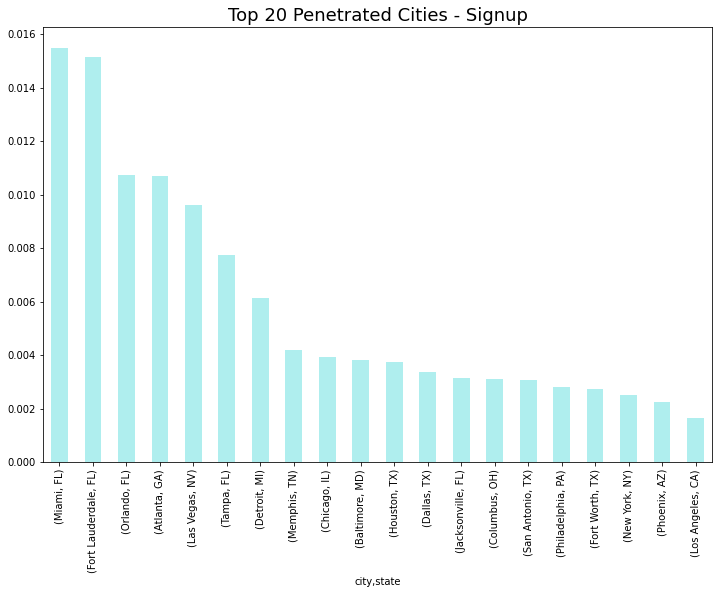

In [32]:
f, ax = plt.subplots(figsize=(12, 8))
# pp.plot(kind='bar',x='city',y='pr', color='paleturquoise', fontsize = 16, ax=ax)
pp.groupby(["city", "state"])["pr"].agg(sum).sort_values(ascending=False).plot(
    kind="bar", color="paleturquoise"
)
ax.set_title("Top 20 Penetrated Cities - Signup", fontsize=18)
plt.show()

In [33]:
# calculate the penetration kycc
kyccp = kyccp.head(20)
kyccp["pr"] = kyccp["kycc"] / kyccp["2019"]
kyccp = kyccp.sort_values("pr", ascending=False)

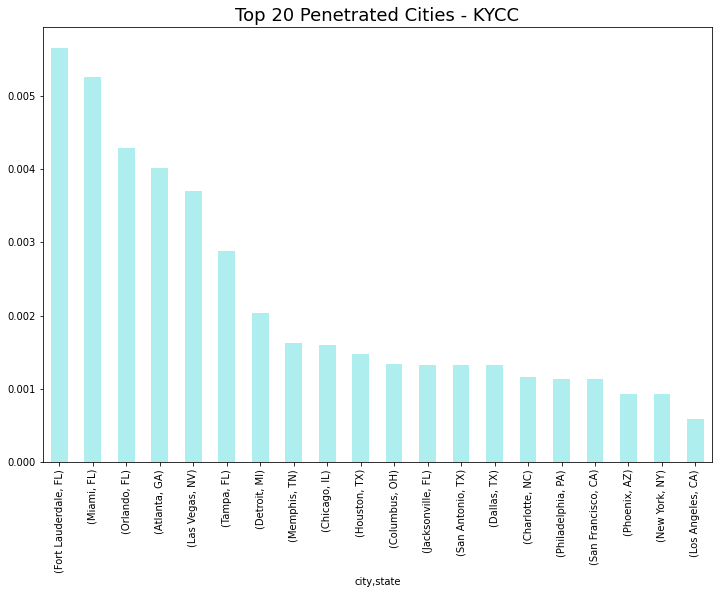

In [34]:
f, ax = plt.subplots(figsize=(12, 8))
kyccp.groupby(["city", "state"])["pr"].agg(sum).sort_values(ascending=False).plot(
    kind="bar", color="paleturquoise"
)
ax.set_title("Top 20 Penetrated Cities - KYCC", fontsize=18)
plt.show()

In [35]:
# calculate the penetration cmau
cmaup = cmaup.head(20)
cmaup["pr"] = cmaup["current_mau"] / cmaup["2019"]
cmaup = cmaup.sort_values("pr", ascending=False)

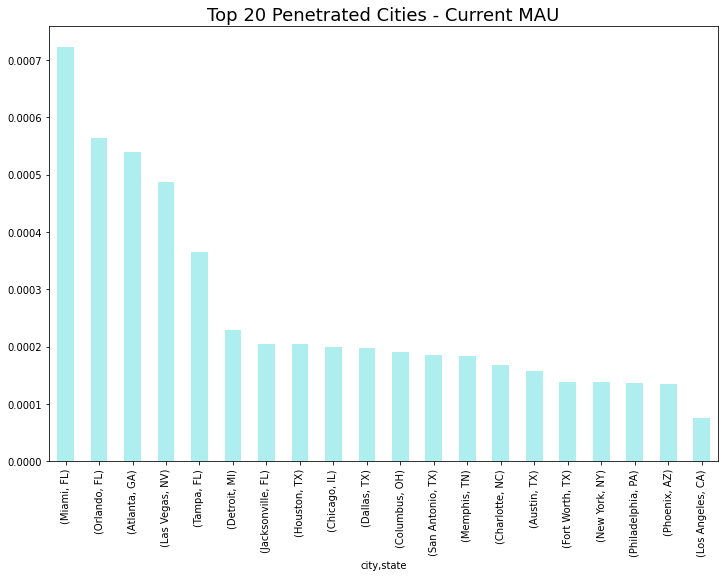

In [36]:
f, ax = plt.subplots(figsize=(12, 8))
cmaup.groupby(["city", "state"])["pr"].agg(sum).sort_values(ascending=False).plot(
    kind="bar", color="paleturquoise"
)
ax.set_title("Top 20 Penetrated Cities - Current MAU", fontsize=18)
plt.show()

### Some Thoughts 
1. The top 10 signup cities are New York, Chicago, Houston, Miami, Los Angeles, Las Vegas, Atlanta, San Antonio, Dallas, and Philadephia. 
2. However, most of them do not have a high penetration rate. Only Miami, Altlanta, Las Vegas, Fort Lauderdale, and Orlando are Top 20 in both signup amounts and penetration rate. Others are not.
3. Most of the cities' signups amount is positively related to the population, when it's not, they either perform very well or not very well
4. Big cities in Eastern area has good signup amounts, as well as some big city in the central area, but when it comes to the penetration rate, they don't perform very well
5. FL and GA have the best penetration rate. Any successful campaigns there? Any experience that applies to NY, PA, and other eastern cities?
6. Besides Los Angeles, other cities' signup amount and penetration are both low in CA, where our competitor Chime is. People there are familiar with the concept, it's an area with opportunities with branding. 